In [78]:
import re
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [79]:
from spellchecker import SpellChecker


In [80]:
spell = SpellChecker()

In [81]:
filename = "elan_dataset_merged.txt"

In [82]:
output_filename = "elan_cleaned_retained_merged.txt"

In [83]:
def get_token(gloss, remove=False):
    
    removed_decorator_start = ""
    removed_decorator_end = ""

    if gloss[:8] == "FBUOY:DS":
        split = gloss.split(':')
        if len(split) > 2:
            gloss = gloss.split(':')[2]
            removed_decorator_start = "FBUOY "
    elif gloss[:6] == "FBUOY:":
        split = gloss.split(':')
        if len(split) > 1:
            gloss = gloss.split(':')[1]
            removed_decorator_start = "FBUOY "
    elif gloss[:6] == "FUBOY:":
        split = gloss.split(':')
        if len(split) > 1:
            gloss = gloss.split(':')[1]
            removed_decorator_start = "FBUOY "
    elif gloss[:6] == "FBOUY:":
        split = gloss.split(':')
        if len(split) > 1:
            gloss = gloss.split(':')[1]
            removed_decorator_start = "FBUOY "
    elif gloss[:6] == "GICA):":
        split = gloss.split(':')
        if len(split) > 1:
            gloss = gloss.split(':')[1]
    elif gloss[:6] == "TBUOY:":
        split = gloss.split(':')
        if len(split) > 1:
            gloss = gloss.split(':')[1]
            removed_decorator_start = "FBUOY "
    elif gloss[:3] == "FS:":
        gloss = gloss[3:]
        removed_decorator_start = "FS "
    elif gloss[:3] == "FB:":
        gloss = gloss[3:]
        removed_decorator_start = "FB "
    elif gloss[:2] == "DS":
        split = gloss.split(':')
        if len(split) > 1:
            gloss = gloss.split(':')[1]
            removed_decorator_start = "DS "
    elif gloss[:2] == "G(":
        split = gloss.split(':')
        if len(split) > 1:
            gloss = gloss.split(':')[1]
    elif gloss[:3] == "CA:":
        split = gloss.split(':')
        if len(split) > 1:
            gloss = gloss.split(':')[1]
    elif gloss[:3] == "GA:":
        split = gloss.split(':')
        if len(split) > 1:
            gloss = gloss.split(':')[1]
    elif gloss[:2] == "G:":
        split = gloss.split(':')
        if len(split) > 1:
            gloss = gloss.split(':')[1]
    elif gloss[:2] == "M:":
        split = gloss.split(':')
        if len(split) > 1:
            gloss = gloss.split(':')[1]
    elif gloss[:7] == "FINISH.":
        gloss = "FINISH"

    index = gloss.find("-2H")
    if index != -1:
        gloss = gloss[:index]
        removed_decorator_end = " 2H"
    index = gloss.find("-1H")
    if index != -1:
        gloss = gloss[:index]
        removed_decorator_end = " 1H"
    index = gloss.find("2-H")
    if index != -1:
        gloss = gloss[:index]
        removed_decorator_end = " 2H"
    index = gloss.find("1-H")
    if index != -1:
        gloss = gloss[:index]
        removed_decorator_end = " 1H"

    index = gloss.find("(")
    if index != -1:
        gloss = gloss[:index]
    
    if remove:
        return gloss
    return f'{removed_decorator_start}{gloss}{removed_decorator_end}'

In [84]:
def clean_sentence(sentence):
    
    sentence = sentence.replace("'s", " is")
    sentence = sentence.replace("n't", " not")
    sentence = sentence.replace("'d", " had")
    sentence = sentence.replace("'ll", " will")
    sentence = sentence.replace("'m", " am")
    sentence = sentence.replace("'ve", " have")
    sentence = sentence.replace("'re", " are")
    sentence = sentence.replace("ahh", "")
    sentence = sentence.replace("umm", "")
    sentence = sentence.replace("?", " ?")
    sentence = sentence.replace("(", "")
    sentence = sentence.replace(")", "")



    cleaned_sentence = ""
    
    for char in sentence:
        if char.isalpha() or char == "'" or char == "?":
            cleaned_sentence += char
        else:
            cleaned_sentence += " "
    
    cleaned_sentence = cleaned_sentence.lower()
    cleaned_sentence = re.sub(' +', ' ', cleaned_sentence)
    
    return cleaned_sentence.strip()

def should_skip_token(token):
    if token[:3] == "PT:":
        return True
    if token[:5] == "LOOK(":
        return True
    if token[:7] == "PTBUOY:":
        return True
        
    return False
    
def clean_tokens(token_sequence):
    
    token_sequence = token_sequence.replace("FALSE-START", "")
    token_sequence = token_sequence.replace("FALSE START", "")
    token_sequence = token_sequence.replace("?", " ?")
    tokens = token_sequence.strip().split(" ")
    
    
    cleaned_tokens = []
        
    for token in tokens:
        if token[:3] == "PT:":
            continue
        if token[:5] == "LOOK(":
            continue
        if token[:7] == "PTBUOY:":
            continue
        
        token = get_token(token)
        
        if token in ["WELL", "", "AHH", "UMM", "FSL", "PTBUOY", "HMM", "ERR", "PHOOEY", "INDETERMINATE", "INDECIPHERABLE"]:
            continue

        if token[-1].isdigit():
            token = token[:-1]

        if len(token) < 2:
            continue
                        
        cleaned_tokens.append(token)
        
    unduped_tokens = []
    
    for i in range(0, len(cleaned_tokens)):
        if (i == 0 or cleaned_tokens[i] != cleaned_tokens[i - 1]) and (i < 2 or cleaned_tokens[i] != cleaned_tokens[i - 2]):
            unduped_tokens.append(cleaned_tokens[i].replace("-", " "))
        
    return (" ".join(unduped_tokens)).upper()

def spell_check(sequence, upper):
    sequence = sequence.split(" ")
    output = []
    for word in sequence:
        if upper:
            if spell.correction(word):
                output.append(spell.correction(word).upper())
            else:
                output.append(word)
        else:
            if spell.correction(word):
                output.append(spell.correction(word))
            else:
                output.append(word)
    return " ".join(output)

def create_output_file(input_filename, output_filename):
    input_file = open(input_filename, "r")
    output_file = open(output_filename, "w+")
    lines = input_file.readlines()
    
    cleaned_lines = []
        
    for line in lines:
        split = line.split("\t")
        
        sentence = clean_sentence(clean_sentence(split[0]))
        if len(sentence) == 0:
            continue
#         sentence = spell_check(sentence, False)

        
        tokens = clean_tokens(clean_tokens(split[1]))
        if len(tokens) == 0:
            continue
#         tokens = spell_check(tokens, True)
        
        if (len(sentence) == 0 or len(tokens) == 0) or sentence.count(" ") > 25 or tokens.count(" ") > 25:
            continue
            
        print(split[1])
        print(tokens)
        print()
        
        cleaned_lines.append(f'{clean_sentence(split[0])}\t{clean_tokens(split[1])}\n')
        
    cleaned_lines.sort(key= lambda line: (line.split("\t")[0].count(" ")))
    
    text = ""
    
    for cleaned_line in cleaned_lines:
        text += cleaned_line
        
    output_file.write(text)
    output_file.close()
    input_file.close()
    
    return cleaned_lines

In [85]:
sentences = create_output_file(filename, output_filename)

PT:LOC(ILY) G(ILY):UMM LOOK(FALSE START) see TELEPHONE1 RINGING-PHONE-2H G(INDEFINITE):UMM FS:COUNTER DSS(5):COUNTER

SEE TELEPHONE RINGING PHONE 2H FS COUNTER DS

MAN SLIDE1(BENT2) CA:MAN GRAB-2H TELEPHONE1 DSL(6):HOLDING-TELEPHONE FBUOY:TELEPHONE1 SAME PROUD1 TELEPHONE(FALSE-START) SAME SPIDER gaining someone's favour.

MAN SLIDE GRAB 2H TELEPHONE DS HOLDING TELEPHONE FBUOY SAME PROUD TELEPHONE SAME SPIDER GAINING SOMEONE'S FAVOUR.

TELEPHONE2 HELLO1 FBUOY:TELEPHONE2 SURPRISE3 FBUOY:TELEPHONE2 PT:BUOY FBUOY:TELEPHONE2 OLD FBUOY:TELEPHONE2 LADY1 TALK WANT PT:PRO3SG(7) PLEASE2 GO-POINT G(5):UMM HELP LUGGAGE G(BENT2):UMM LUGGAGE MAN ALRIGHT

TELEPHONE HELLO FBUOY TELEPHONE SURPRISE OLD LADY TALK WANT PLEASE GO POINT HELP LUGGAGE MAN ALRIGHT

TELEPHONE2 BUT2 G(1):UMM IN CAT2(X) PT:LOC IN PT:LOC(6) PT:LOC CHECK2 LETTER DSS(B-LATERAL):PIGEON-HOLE HEAR2 STEAL HEAR2 ENJOY2 SURPRISE3

TELEPHONE BUT IN CAT CHECK LETTER DS PIGEON HOLE HEAR STEAL ENJOY SURPRISE

G:UMM FS:SO PT:PRO3SG   CAT2(X) D


DS ANIMAL MOVES GO

DOG1 DSM(2-DOW):ANIMAL-RUNS DSM(1-HORI):ANIMAL-MOVES

DOG DS ANIMAL RUNS DS ANIMAL MOVES

DSM(4-WIGGLE):MANY-ANIMALS-MOVE FS:BEE

DS MANY ANIMALS MOVE FS BEE

G(CA): WALK-1H DSS(BC):ROUND-ROCK? ROCK DSS(BENT5):LARGE-ROCK

WALK 1H DS ROUND ROCK DS LARGE ROCK

DSS(BENT5):LARGE-ROCK DSM(2):HUMAN-CLIMBS-ROCK

DS LARGE ROCK DS HUMAN CLIMBS ROCK

DSS(5):LONG-THIN-OBJECTS-EXTEND WHAT BUSH FS:BRANCH

DS LONG THIN OBJECTS EXTEND WHAT BUSH FS BRANCH

G(CA):BOY-HOLDS-BRANCHES SHOUT G(NMS):BOY-YELLS DOG1 SUMMON G(CA):BOY-HOLDS-BRANCHES DSM(1-HORI):ANIMAL-MOVES DSM(1-DOWN):ANIMAL-WALKS DSM(1-HORI):ANIMAL-MOVES

BOY HOLDS BRANCHES SHOUT BOY YELLS DOG SUMMON BOY HOLDS BRANCHES DS ANIMAL MOVES DS ANIMAL WALKS

G(CA):BOY-HOLDS-BRANCHES WHAT FOUR SURPRISED DEER DSL(2):BOY-ON-DEER DSM(2):ANIMAL-MOVES

BOY HOLDS BRANCHES WHAT FOUR SURPRISED DEER DS BOY ON DEER DS ANIMAL MOVES

WITH1 DOG1 DSM(1-HORI):ANIMAL-MOVE-AT-DEER SHOUT DSM(1-HORI):ANIMAL-MOVE

WITH DOG DS ANIMAL MOVE AT DEER SHO


THINK PERHAPS FROG DS ROUND HOLE

FS:FERRET BITE

FS FERRET BITE

G(CA): DOG1 CHASE FS:BEES FS:HIVES

DOG CHASE FS BEES HIVES

GO-POINT G(HOLD-PAUSE):UMM PUSH TREE1 BOY WALK-1H TREE1 PT:DET(RELAXED) HAVE HOLE2 DSL(GC):ROUND-HOLE-BE-AT

GO POINT PUSH TREE BOY WALK 1H TREE HAVE HOLE DS ROUND HOLE BE AT

YELL2 FBUOY:DS(GC):THE-HOLE PERHAPS FBUOY:DS(GC):THE-HOLE FROG FBUOY:DS(GC):THE-HOLE DSS(GC):ROUND-HOLE

YELL FBUOY THE HOLE PERHAPS FROG DS ROUND HOLE

PT:DET(RELAXED) OWL FLY1 YELL2-2H

OWL FLY YELL 2H

BOY G:OH SHOCKED DSM(BENT2):HUMAN-FALLS-BACK DSG(BC):GROUND

BOY OH SHOCKED DS HUMAN FALLS BACK DS GROUND

DOG1 PT:DET PUSH PT:DET-2H(RELAXED) PT:DET-2H FS:BEEHIVES(BEEHVES) DSL(5):-SPHERICAL-BEEHIVE-BE-AT

DOG PUSH FS BEEHIVES DS SPHERICAL BEEHIVE BE AT

DSL(5):-SPHERICAL-BEEHIVE-BE-AT PUSH

DS SPHERICAL BEEHIVE BE AT PUSH

DSM(BC):ROUND-BEEHIVE-FALLS DSS(B):FLAT-SURFACE

DS ROUND BEEHIVE FALLS DS FLAT SURFACE

DOG1 RUN2 PT:DET FS:BEES CHASE-1H FOLLOW

DOG RUN FS BEES CHASE 1H FOLLOW




DS BEES FLY DS MANY ANIMALS MOVE

FOR? DOG2 PT:FBUOY G(CA):ANIMAL-FEET-RUN ZOOM-OFF PT:PRO3SG DSM(BENT2-HORI):HUMAN-WALK

FOR DOG ANIMAL FEET RUN ZOOM OFF DS HUMAN WALK

ROCK DSS(BENT5):ROUND-ROCK HAVE-2H DSS(F):CYLINDRICAL-OBJECT-EXTEND TREE DSS(5):CYLINDRICAL-BRANCHES-EXTEND

ROCK DS ROUND ROCK HAVE 2H DS CYLINDRICAL OBJECT EXTEND TREE DS CYLINDRICAL BRANCHES EXTEND

CLIMB1

CLIMB

G(CA):BOY-PULLS-HIMSELF-UP-ON-ROCK CLIMB2

BOY PULLS HIMSELF UP ON ROCK CLIMB

G(CA):BOY-HOLDS-ON SURPRISED DEER DSM(P):HUMAN-LIES-ON-DEER

BOY HOLDS ON SURPRISED DEER DS HUMAN LIES ON DEER

G(CA):BOY-HOLDS-ANTLERS DEER DOG2 DEER DOG2 DEER DSM(2-DOWN):DEER-RUNS

BOY HOLDS ANTLERS DEER DOG DS DEER RUNS

GO WATER CLIFF FS:LAKE DSS(1):ROUND-EDGE-OF-LAKE

GO WATER CLIFF FS LAKE DS ROUND EDGE OF LAKE

DEER DSM(2-DOWN):HUMAN-FALL-FROM-DEER(FALSE-START)

DEER DS HUMAN FALL FROM DEER

BOY DSM(2-DOWN):HUMAN-FALL-FROM-DEER DSL(RELAXED):HEAD-OF-DEER

BOY DS HUMAN FALL FROM DEER DS HEAD OF DEER

DOG2 DSM(BENT2):HUMAN

BOY DSM(BENT2):HUMAN-JUMPS-DOWN

BOY DS HUMAN JUMPS DOWN

G(CA):HUMAN-GETS-THE-DOG-AND-CARRIES-IT CHERISH DOG1 ALRIGHT G(CA):HUMAN-RUBS-THE-DOG G(CA):HUMAN-CARRIES-THE-DOG TRY DSM(BENT2-HORI):ONE-OF-THEM-WALKS

HUMAN GETS THE DOG AND CARRIES IT CHERISH DOG ALRIGHT HUMAN RUBS THE DOG HUMAN CARRIES THE DOG TRY DS ONE OF THEM WALKS

SEARCH

SEARCH

WHERE FROG WHERE SEARCH DSM(BENT2):ONE-OF-THEM-WALKS

WHERE FROG SEARCH DS ONE OF THEM WALKS

LOOK PT:LOC HAVE HOLE2 HOLE1

LOOK HAVE HOLE

LOOK FBUOY:HOLE1

LOOK FBUOY HOLE

DOG2 BUSY WITH1 PT:DET DSS(BENT5):SPHERICAL-BEEHIVE FS:BEE DSS(BENT5):SPHERICAL-BEEHIVE FS:HIVE

DOG BUSY WITH DS SPHERICAL BEEHIVE FS BEE HIVE

DSL(BC):ROUND-BEEHIVE-UP-THERE

DS ROUND BEEHIVE UP THERE

DSL(BC):ROUND-BEEHIVE-UP-THERE LOOK FBUOY:DSL(BC):THE-BEEHIVE-UPTHERE BEG3 LOOK

DS ROUND BEEHIVE UP THERE LOOK FBUOY THE BEEHIVE UPTHERE BEG LOOK

BOY LOOK PT:LOC/PRO3SG DSS(1):ROUND-HOLE

BOY LOOK DS ROUND HOLE

FBUOY:PT:LOC/PRO3SG WHAT DSS(BC):ROUND-HOLE LOOK

FBUOY PT 

In [86]:
sentences

['sorry\tSORRY\n',
 'hmm\tTHINKING POSURE THINKING POSTURE\n',
 '?\tGO TRACE\n',
 'quiet\tQUIET\n',
 'bye\tFBUOY G BYE\n',
 'shoo\tSHOO\n',
 'farms\tFS FARMS FARM\n',
 'xxx\tNEXT DAY MORNING BOY FS DOG SEARCH SEARCH 2H GONE1 2H SEARCH SEARCH 2H WINDOW DS VERTICAL WINDOWSILL GONE1 2H DS HUMAN SITS ON THE WINDOWSILL DS THE WINDOWSILL\n',
 'nothing\tBOY LIFTS AND CHECKS HAVE NOT\n',
 'bye\tTAKE BYE\n',
 'nothing\tNOT\n',
 'bored\tBORING\n',
 'nothing\tNOTHING DS CURVED SURFACE OF LOG\n',
 'log\tDS ANIMALS IN A ROW\n',
 'fine\tFINE\n',
 'good\tGOOD\n',
 'bye\tBYE\n',
 'the beehive\tTREE DS BEEHIVE BE AT\n',
 'he smiles\tSMILE\n',
 'look there\tDS SHAPE OF TREE\n',
 'he walked\tBIRD FLY WALK 1H\n',
 'hare sits\tFS RABBIT SIT ON\n',
 'the hare\tTHE\n',
 'he plodded\tTIME WATCH DS FEET STEP\n',
 'he sprinted\tSPRINT\n',
 'he arrived\tARRIVE\n',
 'he thought\tTHINK\n',
 'i know\tTHINK\n',
 'they thought\tTHINK\n',
 'he sleeps\tBED2 2H\n',
 'he searches\tSEARCH\n',
 'he thinks\tTHINK\n',
 'they

In [87]:
def plot_hist(sentences, index, bins, title, ylabel, xlabel):
    sentence_lengths = []

    for line in sentences:
        sentence = line.split("\t")
        count = sentence[index].count(" ")
        sentence_lengths.append(count + 1)
    
    plt.figure(figsize=(14,7)) # Make it 14x7 inch
    plt.style.use('seaborn-whitegrid') # nice and clean grid

    n, bins, patches = plt.hist(sentence_lengths, bins=bins, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

    n = n.astype('int') # it MUST be integer

    # Good old loop. Choose colormap of your taste
    for i in range(len(patches)):
        patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))


    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

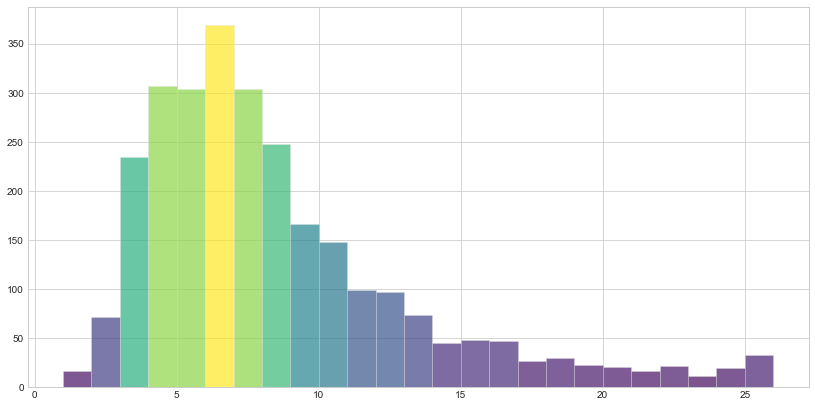

In [88]:
plot_hist(sentences, 0, 25, "", "", "")